# Parte 1: DCCasas

Nota de los ayudantes: Por motivos de desempeño de las redes neuronales, recomendamos realizar esta tarea en Google Colab.

### Importando los datos

In [2]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import os
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from datetime import datetime
from scipy.sparse import csr_matrix

In [3]:
# Creamos una semilla para que los resultados sean replicables
n_alumno = 23103435
np.random.seed(n_alumno)

In [ ]:
# Mediante las siguientes líneas podrás descargar la base de datos en la carpeta multimodal_house_prices/ si utilizas google colab, en caso contrario descárgala directamente desde el link
!gdown https://drive.google.com/uc?id=1078WtQHBTCe5amlDtfu3bgPbO9PFd31R
!unzip --qq multimodal_house_prices.zip

In [4]:
#path = '/multimodal_house_prices/'   # Si corres el notebook a nivel local
path = 'multimodal_house_prices/'   # Si corres el notebook en google colab

# Importamos el csv
meta_data = pd.read_csv(path + "data.csv")

# Veamos las primeras 5 observaciones
meta_data.head()

,image_id,street,city,bedrooms,bathrooms,sqft,price
0,1,124 C Street W,"Brawley, CA",3,2.0,713,228500
1,4,2207 R Carrillo Court,"Calexico, CA",4,3.0,2547,385100
2,6,1100 CAMILIA Street,"Calexico, CA",4,3.0,2769,415000
3,7,803 Chaparral Court,"Brawley, CA",5,2.1,2600,545000
4,8,803 Chaparral Court,"Brawley, CA",5,2.1,2600,545000


In [5]:
# Preparación de datos para el MLP
X_mlp = meta_data.drop(['price', 'image_id'], axis=1)

# Definir la variable objetivo
y = np.array(meta_data["price"].tolist())

# Función para extraer características de una imagen
def image_processing(file):
    image = cv2.imread(file)

    # Obtén las dimensiones de la imagen
    height, width = image.shape[:2]

    # Verifica si la imagen ya tiene las dimensiones deseadas
    if height == 311 and width == 415:
        return image
    else:
        # Redimensiona la imagen a 415x311 con interpolación lineal
        resized_image = cv2.resize(image, (415, 311), interpolation=cv2.INTER_LINEAR)
        return resized_image
    return image

# Lista vacía para guardar los datos procesados
extracted_cnn = []

# Iterar sobre cada fila del DataFrame
for index_num, row in tqdm(meta_data.iterrows()):
    # Obtener el path de la imagen
    file_name = os.path.join(os.path.abspath(path), 'images/' +  str(row['image_id']) + '.jpg')

    # Obtener el valor objetivo (por ejemplo, el precio)
    target_value = row['price']

    # Usar la función definida arriba para procesar la imagen
    data = image_processing(file_name)

    # Guardar la imagen redimensionada
    extracted_cnn.append(data)

# Definir los datos para la CNN
X_cnn = np.array(extracted_cnn)

12518it [00:39, 314.75it/s]


### Actividad 1: Importando y comprendiendo los datos

* Investiga y describe por qué el preprocesamiento es una etapa crucial para las redes neuronales. Explica cómo los pasos de preprocesamiento pueden afectar el rendimiento de un modelo.

\\

El preprocesamiento consiste básicamente en limpiar la data; organizarla, volverla numérica y homogénea y quitar la data ruidosa, lo cual permite que la red pueda procesar los datos y encontrar patrones de forma efectiva. Es decir, hacer que los datos a procesar sean de la mejor calidad posible, de tal forma que el modelo pueda predecir correctamente y no lo haga a partir de ruido. Por ejemplo, algo común es que hayan valores perdidos, los cuales podremos excluir o rellenar, o si tenemos 2 tipos de datos de texto (como "positivo" y "negativo"), los volvemos 0 o 1.

Ahora, hay que tener cuidado con estos pasos, pues de vez en cuando pueden llevar a sesgo, por ejemplo, si se suaviza demasiado una data, podría ocurrir que ciertos features espaciales sean atenuados o derechamente no sean de utilidad, ya que se homogeneizó el espacio.

Por otro lado, eliminar el ruido evita la generación de features que realmente no tenían ningún significado, y evita así que el modelo les tome importancia.

\\

de https://www.sciencedirect.com/science/article/pii/B9780128144824000024?fr=RR-2&ref=pdf_download&rr=8326537df84ed76e

https://www.sciencedirect.com/science/article/pii/B9780128212295000033?ref=pdf_download&fr=RR-2&rr=832654c13f7bd746

* Si tuviéramos pocas imágenes para entrenar un modelo, ¿qué técnicas podrías usar para enriquecer el conjunto de datos? Investiga sobre el aumento de datos en imágenes.

\\

Una técnica es el aumento de data, donde por lo general, se modifican ligeramente las imágenes ya existentes en el dataset y se incluyen como nueva data. Estos cambios suelen ser rotaciones, cambios de tamaño, zoom, cambios de colores, o de contrastes o brillo, o incluso borrar pequeñas partes de la imagen original, de tal forma que la información siga siendo de utilidad para el modelo, pero genere nueva información en vez de hacer que el programa solo memorice. Se debe hacer una verificación de la imagen luego de las modificaciones para asegurarse de no haber modificado demasiado estas para no ser de utilidad para lo que queremos.

Otra forma de generar nueva data es usar imágenes sintéticas generadas por otras inteligencias artificiales.

\\

de https://www.datacamp.com/tutorial/complete-guide-data-augmentation 

### Actividad 2: Explorando los Multilayer Perceptron (MLP)

* Discute cómo la profundidad y el ancho (número de capas y neuronas por capa) de un MLP afectan su capacidad para aprender patrones complejos. ¿Cuáles son los desafíos relacionados con el aumento de la complejidad del modelo?

\\

La profundidad y el ancho modelan la complejidad del modelo, su rendimiento y capacidad de aprendizaje.

La profundidad del MLP es la que modela representaciones más complejas de los datos, y mientras más profundas, más complejas. Esto es similar a lo visto en clases con los random forest, y tal como en este caso, si la red es demasiado profunda, podríamos llegar a un sobreajuste. Por otro lado, entrenar redes muy profundas puede ser costoso y requerir mucho tiempo de cómputo.

Otra cosa a notar es que los errores se van propagando por las capas, pero se reducen exponencialmente junto a estas, sin embargo esto a su vez impide que se realice bien el ajuste de pesos backpropagation, por lo que hay que tener cuidado aquí también.

El ancho de la red como es imaginable, modela la capacidad de aprendizaje del modelo sobre los patrones de los datos para poder clasificarlos, ya que mientras más neuronas, más patrones se podrán capturar, por tanto redes anchas pueden adaptarse mejor a relaciones más complejas.

Al igual que antes, redes más anchas pueden llevar a más sobreajuste si los datos son muy pocos, y demoran más tiempo de cómputo tanto en el entrenamiento como en el testeo y validación. Por tanto debemos tener un buen balance a la hora de decidir el ancho y la profundidad del MLP.

Entnonces, la profundidad y ancho que elijamos dependerá de cuán complejas sean las relaciones de nuestros datos, no siempre necesitaremos mucha complejidad.

\\ 

de https://www.v7labs.com/blog/data-augmentation-guide 
https://medium.com/@guillaumelbr13/what-is-a-wide-deep-learning-model-b12dd469f891#:~:text=To%20understand%20the%20use%20of,model%20is%20used%20for%20generalization. 

https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/ 

* Investiga y compara al menos dos funciones de activación no lineales diferentes utilizadas en MLPs. ¿Cómo afectan estas funciones al tipo de decisiones que puede aprender la red? Considera aspectos como la saturación y la no linealidad.

\\

Una función de activación en una red neuronal define cómo la suma de los inputs se transforma al output. La elección de estas tendrá un gran impacto en el funcionamiento de la red. En general, están las lineales y las no lineales, y dentro de este grupo tendremos varias funciones que suelen ser ocupadas con mayor frecuencia, por ejemplo:

- Relu: Esta se usa bastante hoy en día, significa Rectified Linear Unit. Es bastante eficiente computacionalmente, esto porque solo activa algunas neuronas y no todas. Otra ventaja es que permite el uso de backpropagation de forma muy eficiente para llegar al mínimo, ya que la forma de la curva es lineal desde cierto punto, permitiendo que converja a un mínimo global. En general no se satura, ya que la derivada nunca se hace 0 en la zona lineal. Esta tiene la forma de:

$$ f(x) = max(0, x) $$

Por tanto, su rango va de 0 a infinito. Sin embargo, como cierta parte de la función cae a una línea horizontal en 0, el gradiente igual, por tanto los pesos de ciertas neuronas no se actualizarán y por tanto estas no se activan y no serán de utilidad. Este problema se llama "Dying Relu problem", aunqeu en algunos casos esto podría ser útil, pero en caso contrario, se puede usar "Leaky ReLu", función que soluciona este problema.

- Sigmoide: También conocida como la función logística. Sus valores van de 0 a 1, por tanto se puede interpretar como una probabilidad, por tanto valores muy bajos van a 0 y valores muy altos a 1. Pese a ser buena para clasificar, tiene un gran problema, y es que satura y mata a los gradientes, y el output no está centrado en 0, por lo que el gradiente, pese a ser "suave" debe ir en direcciones distintas, haciendo que la red no pueda seguir aprendiendo o lo haga de forma muy lenta. El gradiente vemos que tiene puntos donde muere, pues tiene la forma de:

$$ f'(x) = sigmoid(x)*(1-sigmoid(x)) $$


Entre estas dos funciones, ReLu es más eficiente y resuelve el problema del "vanishing gradient", que fue lo explicado en el párrafo anterior, pero sigue teniendo sus propios problemas.

\\

de: https://bootcampai.medium.com/redes-neuronales-13349dd1a5bb
https://telefonicatech.com/blog/las-matematicas-del-machine-learning-funciones-de-activacion
https://www.kdnuggets.com/2022/06/activation-functions-work-deep-learning.html#:~:text=Binary%20Step%20Activation%20Function&text=The%20activation%20function%20compares%20the,the%20next%20or%20hidden%20layer.
https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/ 
https://www.v7labs.com/blog/neural-networks-activation-functions


* Examina las causas y síntomas del overfitting en MLP. ¿Qué técnicas se pueden aplicar para prevenir este problema y cómo afectan el proceso de aprendizaje?

\\

Como vimos en clases, el overfitting se produce cuando el modelo se entrena con muchos datos, tal que comienza a aprender de datos defectuosos o ruidosos o memoriza la información y ya no es capaz de generalizar.

Una solución es utilizar algoritmos lineales, pues es un modelo realista para datos lineales, pero esto está claramente limitado para ciertos datos posibles.

Otra idea es analizar la validación del set de datos para ir controlando el bias y la varianza, y que este conjunto tenga datos muy variados, e ir cambiando las condiciones para que el modelo prediga lo mejor posible en este set, y que los datos de entrenamiento estén balanceados. Se puede ocupar validación cruzada, la cual evalúa de forma robusta el rendimiento. Esto funcionaría bastante bien para mejorar la varianza.

A veces conviene prevenir una cantidad excesiva de features que no tengan tanto muestreo, seleccionando las más importantes o dándoles más peso, o incorporar más datos de estas clases submuestreadas. Se pueden añadir términos de regularización, los cuales penalizan los coeficientes grandes para ajustar el modelo, lo que permitirá que el modelo aprenda más de estas clases.

También reducir la profundidad del modelo, como vimos en clases, es de utilidad, pero teniendo en consideración que esto podría reducir la complejidad del aprendizaje del modelo.

\\

de: https://protecciondatos-lopd.com/empresas/overfitting/ 
https://telefonicatech.com/blog/que-es-overfitting-y-como-evitarlo-html-2 
https://machinelearningparatodos.com/que-es-el-sobreajuste-u-overfitting-y-por-que-debemos-evitarlo/

* Más allá del SGD (Stochastic Gradient Descent) y Adam, investiga sobre otro método de optimización utilizado en el entrenamiento de MLP. ¿Cuáles son sus características únicas y en qué situaciones podría ser preferible?

Un problema de optimización, como ya sabemos, consiste en maximizar o minimizar una función según sea necesario. En este caso, queremos minimizar la función de coste asociada ak modelo. Uno de estos modelos es Eve:

Es una modificación a Adam basado en Adagrad, que agrega coeficientes que capturan ciertas propiedades de la función objetivo. Es útil para clasificar imágenes o para redes de lenguaje, y funciona con deep neural networks también.

El learning rate es bajo, para evitar divergencias, pero va variando. Primero se introduce un coeficiente escalar dt para ir adaptando el learning rate inicial, tal que:

$$ \alpha_{t} = \frac{\alpha_{1}}{dt} $$

variaciones altas en dt entonces bajarán el learning rate. Entonces, hacemos el valor:

$$ dt = |f_{t} - f_{t-1}| $$


el cual captura la variación de la función f en un tiempo t a un tiempo t+1. Vemos que si la variación es larga, entonces el peso $\alpha_{t}$ será menor. Entonces, esto nos permite que lejos del mínimo demos pasos más largos, y cerca del mínimo demos pasos más cortos hasta llegar al valor correcto de forma simple y, según aseguran sus creadores, computacionalmente eficiente para grandes CNN. Aseguran también haberlo comparado con otros métodos y haber obtenido resultados similares o mejores a otros métodos populares, incluyendo Adam.

\\

de: https://diposit.ub.edu/dspace/bitstream/2445/176952/2/176952.pdf 
https://arxiv.org/pdf/1611.01505.pdf 

* Identifica y analiza un estudio de caso donde se haya utilizado un MLP para resolver un problema real. ¿Qué características del problema hicieron que un MLP fuera una buena elección y cómo se diseñó la arquitectura de la red para adaptarse a las necesidades específicas del problema?

\\

Hace poco hubo un estudio en Valparaíso sobre qué tan bien funcionaba la parcelación de cerebros del proyecto "Human Connectome Proyect" (HCP), el cual tiene una base de datos de imágenes de resonancia magnética (MRI) de cerebros, para ver si su algoritmo segmentaba bien las zonas del cerebro y funcionaba en operaciones de gliomas (un tipo de tumor) cerebrales. 

Esta segmentación no había sido testeada de antemano de forma clínica, y para esto testearon a 40 pacientes con gliomas, y para realizar la planificación de la extracción del tumor, se utilizó esta representación del cerebro, mientras los pacientes realizaban tareas del lenguaje y motoras, de forma de asegurarse de no afectar estas áreas del cerebro tras la cirugía. Se testearon los resultados y se operaron a los pacientes mientras estaban despiertos y se obtuvieron buenos resultados para ambas áreas.

La parcelación HCP automatizada se realiza a través de un modelo de machine learning capaz de reconocer las distintas áreas en una gran variedad de cerebros. Se separaron tres grupos, entrenamiento, testeo, y un pequeño grupo de validación de pacientes que compartían lazos sanguíneos con personas del grupo de entrenamiento.

Se pre-procesaron las imágenes y luego se extrajeron los features.

Se realizaron estos features midiendo la conectividad entre funcional entre distintos voxels del cerebro (es decir, se midió qué tan parecida era la actividad entre distintos puntos del cerebro) usando la correlación de Pearson. Se agruparon los features entre los que se hicieron con los sujetos en reposo, realizando alguna actividad, el grosos cortical, etc.

Se utilizó un clasificador supervisado para delinear las zonas del cerebro, a partir de imágenes delineadas por expertos en neuroanatomía, y así delimitar 180 zonas por hemisferio a partir de esto. 

Se utilizó un multilayer perceptron para generar outputs de 0 a 1 de qué tan posible es que cierta delimitación sea parte de un área que se esté clasificando dado las zonas que tiene alrededor y su activación, y se utilizó un "sensitivity metric" para clasificar, la cual era la derivada parcial de cada feature de cada área multiplicado por la magnitud del gradiente de ese feature.

Se utilizó cross-validation, y se ocuparon imágenes de un mismo sujeto, pero en una sesión MRI distinta para comprobar los resultados.


\\

de: https://pubmed.ncbi.nlm.nih.gov/36455268/ 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4990127/ 

### Implementación de un Multilayer Perceptron (MLP)

* Implementa un MLP con al menos dos capas ocultas. Entrena tu modelo en el conjunto de datos de entrenamiento y realiza ajustes en los hiperparámetros (como la tasa de aprendizaje, número de neuronas, funciones de activación) para mejorar el rendimiento del modelo.

In [73]:
# primero, vemos que la data no está en el formato que necesitamos
# para ser procesados, por tanto debemos convertirlos a valores numéricos:
# vemos que debemos convertir "street" y "city".
# de: https://machinelearninggeek.com/multi-layer-perceptron-neural-network-using-python/

le = LabelEncoder()

X_mlp['street'] = le.fit_transform(X_mlp['street'])
X_mlp['city'] = le.fit_transform(X_mlp['city'])



In [74]:
# Vemos ahora que esto funcionó:

print(X_mlp)

       street  city  bedrooms  bathrooms  sqft
0         992    47         3        2.0   713
1        3652    54         4        3.0  2547
2         395    54         4        3.0  2769
3        9246    47         5        2.1  2600
4        9246    47         5        2.1  2600
...       ...   ...       ...        ...   ...
12513    3896   378         3        3.0  1677
12514    3330   253         5        3.1  4457
12515    6601   220         5        4.1  4092
12516    6833   361         5        3.0  2773
12517    5891   245         4        2.0  2086

[12518 rows x 5 columns]


In [75]:
# normalizamos nuestra data para que el gradiente funcione bien:
sc = StandardScaler()
X = sc.fit_transform(X_mlp)

# creamos con esto test de entrenamiento, test y validación:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# como el dataset es grande, decidí tener porcentajes bajos de test y de validation, pero quise que fuese un poco mayor
# el de validation para comprobar antes que no hubiese nada extraño.


In [76]:
# de: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# https://www.projectpro.io/recipes/what-is-batch-normalization-keras

model = Sequential()
# capa inicial:
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# capas ocultas:
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))


# capa de salida:
model.add(Dense(1, activation='linear'))

# añadimos el optimizador y la función de pérdida:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# fiteamos el modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
235/235 [==============================] - 2s 4ms/step - loss: 600652185600.0000 - mae: 684152.7500 - val_loss: 584482357248.0000 - val_mae: 675995.3750
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 555145887744.0000 - mae: 652936.7500 - val_loss: 468495892480.0000 - val_mae: 593955.7500
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 346111770624.0000 - mae: 482008.0938 - val_loss: 207465463808.0000 - val_mae: 343367.6875
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 166540591104.0000 - mae: 300297.1562 - val_loss: 139098832896.0000 - val_mae: 259102.7969
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 136011235328.0000 - mae: 268069.9688 - val_loss: 126049476608.0000 - val_mae: 244498.9375
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 124164579328.0000 - mae: 255879.6562 - val_loss: 116514922496.0000 - val_mae: 234793.2031
Epoch 7/50
235/2

* Evalúa el rendimiento de tu modelo en el conjunto de datos de prueba. Utiliza métricas relevantes para problemas de regresión, como el error cuadrático medio (MSE).

In [77]:
# Evaluamos:
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Squared Error on Test Set: {loss}')


62/79 [======================>.......] - ETA: 0s - loss: 90385113088.0000 - mae: 223042.0312

79/79 [==============================] - 0s 3ms/step - loss: 89004089344.0000 - mae: 220271.1094
Mean Absolute Error on Test Set: 220271.109375
Mean Squared Error on Test Set: 89004089344.0


In [78]:
# de: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

from sklearn.metrics import r2_score

# No podemos usar accuracy_score, pero podemos usar métricas de regresión como:
y_predv = model.predict(X_val)
r2 = r2_score(y_val, y_predv)
print(f'R^2 Score on Validation Set: {r2}')

y_predt = model.predict(X_test)
r2 = r2_score(y_test, y_predt)
print(f'R^2 Score on Test Set: {r2}')

79/79 [==============================] - 0s 1ms/step
R^2 Score on Validation Set: 0.3434336823282381
79/79 [==============================] - 0s 1ms/step
R^2 Score on Test Set: 0.36795647997000736


In [79]:
# analizamos también la diferencia para ver algo más concreto. Vemos que la diferencia es casi siempre un orden menor
# al valor correcto.
for i in range(1, 100):
    print (i ,"label value:", y_test[i], "estimated value:", y_predt[i], "diferencia:", 100*abs(y_test[i] - y_predt[i])/y_test[i])

1 label value: 699000 estimated value: [680685.6] diferencia: [2.62008226]
2 label value: 599000 estimated value: [526889.4] diferencia: [12.03850167]
3 label value: 1325000 estimated value: [1036050.] diferencia: [21.80754717]
4 label value: 325000 estimated value: [399783.88] diferencia: [23.01042308]
5 label value: 1639000 estimated value: [1716848.9] diferencia: [4.74977883]
6 label value: 1475000 estimated value: [859520.5] diferencia: [41.72742373]
7 label value: 409000 estimated value: [363880.7] diferencia: [11.03161675]
8 label value: 1795000 estimated value: [751137.8] diferencia: [58.15388231]
9 label value: 625000 estimated value: [538636.44] diferencia: [13.81817]
10 label value: 249000 estimated value: [479071.44] diferencia: [92.39816767]
11 label value: 980000 estimated value: [584659.2] diferencia: [40.34089923]
12 label value: 399000 estimated value: [476979.4] diferencia: [19.54371084]
13 label value: 575500 estimated value: [658870.9] diferencia: [14.48668549]
14 la

[800472.1] diferencia: [10.95971913]
80 label value: 380000 estimated value: [539342.25] diferencia: [41.93217105]
81 label value: 900000 estimated value: [474762.72] diferencia: [47.24858681]
82 label value: 299000 estimated value: [621390.3] diferencia: [107.82284699]
83 label value: 599000 estimated value: [587805.1] diferencia: [1.86892738]
84 label value: 1258888 estimated value: [625919.25] diferencia: [50.27998917]
85 label value: 750000 estimated value: [623242.6] diferencia: [16.90098333]
86 label value: 649900 estimated value: [646108.75] diferencia: [0.58335898]
87 label value: 505000 estimated value: [437460.44] diferencia: [13.37417079]
88 label value: 315000 estimated value: [440212.5] diferencia: [39.75]
89 label value: 250000 estimated value: [475481.88] diferencia: [90.19275]
90 label value: 565000 estimated value: [524687.3] diferencia: [7.13498894]
91 label value: 629950 estimated value: [492483.84] diferencia: [21.82175669]
92 label value: 1190000 estimated value: [

*  Realiza al menos dos experimentos variando la arquitectura del MLP o los hiperparámetros. Describe cómo cada cambio afecta el rendimiento del modelo y discute tus hallazgos.

In [88]:
# Cambio 1: función de activación a sigmoide

model1 = Sequential()
model1.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid')) # n_neuronas
model1.add(Dense(64, activation='sigmoid'))
model1.add(Dense(32, activation='sigmoid'))
model1.add(Dense(1, activation='linear')) # con add añadimos el n_layers

# añadimos el optimizador y la función de pérdida:
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# fiteamos el modelo:
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
235/235 [==============================] - 2s 4ms/step - loss: 601799000064.0000 - mae: 684922.3750 - val_loss: 590883061760.0000 - val_mae: 680302.3125
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 601789562880.0000 - mae: 684915.3750 - val_loss: 590874607616.0000 - val_mae: 680296.2500
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 601781698560.0000 - mae: 684909.1250 - val_loss: 590866481152.0000 - val_mae: 680290.2500
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 601773375488.0000 - mae: 684903.5625 - val_loss: 590858354688.0000 - val_mae: 680284.3125
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 601764855808.0000 - mae: 684897.3750 - val_loss: 590850097152.0000 - val_mae: 680278.3125
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 601757057024.0000 - mae: 684891.4375 - val_loss: 590842298368.0000 - val_mae: 680272.3750
Epoch 7/50
235/2

In [89]:
# Evaluamos:
loss1, mae1 = model1.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {mae1}')
print(f'Mean Squared Error on Test Set: {loss1}')

# No podemos usar accuracy_score, pero podemos usar:
y_predv1 = model1.predict(X_val)
r2_11 = r2_score(y_val, y_predv1)
print(f'R^2 Score on Validation Set: {r2_11}')

y_predt1 = model1.predict(X_test)
r2_12 = r2_score(y_test, y_predt1)
print(f'R^2 Score on Test Set: {r2_12}')

 1/79 [..............................] - ETA: 1s - loss: 781661306880.0000 - mae: 773662.5000

79/79 [==============================] - 0s 2ms/step - loss: 618892230656.0000 - mae: 691428.0000
Mean Absolute Error on Test Set: 691428.0
Mean Squared Error on Test Set: 618892230656.0
79/79 [==============================] - 0s 1ms/step
R^2 Score on Validation Set: -3.610430357670202
79/79 [==============================] - 0s 2ms/step
R^2 Score on Test Set: -3.3949309754425476


In [90]:
for i in range(1, 100):
    print (i ,"label value:", y_test[i], "estimated value:", y_predt1[i], "diferencia:", abs(y_test[i] - y_predt1[i])/y_test[i])

1 label value: 699000 estimated value: [317.23926] diferencia: [0.99954615]
2 label value: 599000 estimated value: [317.23926] diferencia: [0.99947039]
3 label value: 1325000 estimated value: [317.23926] diferencia: [0.99976057]
4 label value: 325000 estimated value: [317.23926] diferencia: [0.99902388]
5 label value: 1639000 estimated value: [317.23926] diferencia: [0.99980644]
6 label value: 1475000 estimated value: [317.23926] diferencia: [0.99978492]
7 label value: 409000 estimated value: [317.23926] diferencia: [0.99922435]
8 label value: 1795000 estimated value: [317.23926] diferencia: [0.99982327]
9 label value: 625000 estimated value: [317.23926] diferencia: [0.99949242]
10 label value: 249000 estimated value: [317.23926] diferencia: [0.99872595]
11 label value: 980000 estimated value: [317.23926] diferencia: [0.99967629]
12 label value: 399000 estimated value: [317.23926] diferencia: [0.99920491]
13 label value: 575500 estimated value: [317.23926] diferencia: [0.99944876]
14 l

 [317.23926] diferencia: [0.99960345]
51 label value: 498000 estimated value: [317.23926] diferencia: [0.99936297]
52 label value: 1050000 estimated value: [317.23926] diferencia: [0.99969787]
53 label value: 699000 estimated value: [317.23926] diferencia: [0.99954615]
54 label value: 850000 estimated value: [317.23926] diferencia: [0.99962678]
55 label value: 375000 estimated value: [317.23926] diferencia: [0.99915403]
56 label value: 899900 estimated value: [317.23926] diferencia: [0.99964747]
57 label value: 515000 estimated value: [317.23926] diferencia: [0.999384]
58 label value: 216500 estimated value: [317.23926] diferencia: [0.99853469]
59 label value: 570000 estimated value: [317.23926] diferencia: [0.99944344]
60 label value: 299990 estimated value: [317.23926] diferencia: [0.9989425]
61 label value: 698000 estimated value: [317.23926] diferencia: [0.9995455]
62 label value: 285000 estimated value: [317.23926] diferencia: [0.99888688]
63 label value: 390000 estimated value: [

In [91]:
# Cambio 2: aumento del número de layers

model2 = Sequential()
model2.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='linear'))

# añadimos el optimizador y la función de pérdida:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# fiteamos el modelo:
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
235/235 [==============================] - 2s 4ms/step - loss: 358191529984.0000 - mae: 468187.6250 - val_loss: 119583277056.0000 - val_mae: 241567.5469
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 99834732544.0000 - mae: 229698.0000 - val_loss: 100207542272.0000 - val_mae: 227014.7188
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 91291459584.0000 - mae: 221011.9062 - val_loss: 94252261376.0000 - val_mae: 222649.8125
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 88517083136.0000 - mae: 218523.4062 - val_loss: 90661945344.0000 - val_mae: 217648.1094
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 87077773312.0000 - mae: 216736.8281 - val_loss: 88728920064.0000 - val_mae: 215773.0625
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 86666764288.0000 - mae: 216781.2969 - val_loss: 87798841344.0000 - val_mae: 215915.8125
Epoch 7/50
235/235 [=====

In [92]:
# Evaluamos:
loss2, mae2 = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {mae2}')
print(f'Mean Squared Error on Test Set: {loss2}')

# No podemos usar accuracy_score, pero podemos usar:
y_predv2 = model2.predict(X_val)
r2_21 = r2_score(y_val, y_predv2)
print(f'R^2 Score on Validation Set: {r2_21}')

y_predt2 = model2.predict(X_test)
r2_22 = r2_score(y_test, y_predt2)
print(f'R^2 Score on Test Set: {r2_22}')

79/79 [==============================] - 0s 1ms/step - loss: 89004089344.0000 - mae: 220271.1094
Mean Absolute Error on Test Set: 220271.109375
Mean Squared Error on Test Set: 89004089344.0
79/79 [==============================] - 0s 1ms/step
R^2 Score on Validation Set: 0.32136862240316444
79/79 [==============================] - 0s 1ms/step
R^2 Score on Test Set: 0.38244721209358834


In [93]:
for i in range(1, 100):
    print (i ,"label value:", y_test[i], "estimated value:", y_predt2[i], "diferencia:", abs(y_test[i] - y_predt2[i]))

1 label value: 699000 estimated value: [690106.1] diferencia: [8893.875]
2 label value: 599000 estimated value: [570068.44] diferencia: [28931.5625]
3 label value: 1325000 estimated value: [1051464.] diferencia: [273536.]
4 label value: 325000 estimated value: [531057.7] diferencia: [206057.6875]
5 label value: 1639000 estimated value: [1738998.] diferencia: [99998.]
6 label value: 1475000 estimated value: [803867.44] diferencia: [671132.5625]
7 label value: 409000 estimated value: [400819.2] diferencia: [8180.8125]
8 label value: 1795000 estimated value: [775192.7] diferencia: [1019807.3125]
9 label value: 625000 estimated value: [551920.4] diferencia: [73079.625]
10 label value: 249000 estimated value: [391526.4] diferencia: [142526.40625]
11 label value: 980000 estimated value: [544333.4] diferencia: [435666.625]
12 label value: 399000 estimated value: [466747.9] diferencia: [67747.90625]
13 label value: 575500 estimated value: [675836.6] diferencia: [100336.625]
14 label value: 598

In [94]:
# Cambio 3: aumento del número de neuronas

model3 = Sequential()
model3.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(300, activation='relu'))
model3.add(Dense(300, activation='relu'))
model3.add(Dense(1, activation='linear'))

# añadimos el optimizador y la función de pérdida:
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# fiteamos el modelo:
history = model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 549220974592.0000 - mae: 646376.8750 - val_loss: 320382009344.0000 - val_mae: 465124.9062
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 150498377728.0000 - mae: 282720.8750 - val_loss: 121268092928.0000 - val_mae: 238501.4688
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 102867460096.0000 - mae: 232562.2500 - val_loss: 106160324608.0000 - val_mae: 226987.5000
Epoch 4/50
235/235 [==============================] - 1s 2ms/step - loss: 93934796800.0000 - mae: 223260.7500 - val_loss: 98155356160.0000 - val_mae: 222870.5469
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 90255491072.0000 - mae: 220324.7500 - val_loss: 94119051264.0000 - val_mae: 220764.8125
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 88243879936.0000 - mae: 218354.2344 - val_loss: 92697116672.0000 - val_mae: 222485.3438
Epoch 7/50
235/235 [==

In [95]:
# Evaluamos:
loss3, mae3= model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {mae3}')
print(f'Mean Squared Error on Test Set: {loss3}')

# No podemos usar accuracy_score, pero podemos usar:
y_predv3 = model3.predict(X_val)
r2_31 = r2_score(y_val, y_predv3)
print(f'R^2 Score on Validation Set: {r2_31}')

y_predt3 = model3.predict(X_test)
r2_32 = r2_score(y_test, y_predt3)
print(f'R^2 Score on Test Set: {r2_32}')

 1/79 [..............................] - ETA: 2s - loss: 118082248704.0000 - mae: 241416.8281

79/79 [==============================] - 0s 1ms/step - loss: 89004089344.0000 - mae: 220271.1094
Mean Absolute Error on Test Set: 220271.109375
Mean Squared Error on Test Set: 89004089344.0
79/79 [==============================] - 0s 1ms/step
R^2 Score on Validation Set: 0.34095117416152776
79/79 [==============================] - 0s 1ms/step
R^2 Score on Test Set: 0.3729159953220321


In [96]:
for i in range(1, 100):
    print (i ,"label value:", y_test[i], "estimated value:", y_predt3[i], "diferencia:", abs(y_test[i] - y_predt3[i]))

1 label value: 699000 estimated value: [682636.] diferencia: [16364.]
2 label value: 599000 estimated value: [546635.44] diferencia: [52364.5625]
3 label value: 1325000 estimated value: [1055661.4] diferencia: [269338.625]
4 label value: 325000 estimated value: [462765.62] diferencia: [137765.625]
5 label value: 1639000 estimated value: [1773315.6] diferencia: [134315.625]
6 label value: 1475000 estimated value: [838949.75] diferencia: [636050.25]
7 label value: 409000 estimated value: [398666.22] diferencia: [10333.78125]
8 label value: 1795000 estimated value: [746305.5] diferencia: [1048694.5]
9 label value: 625000 estimated value: [544975.75] diferencia: [80024.25]
10 label value: 249000 estimated value: [473130.7] diferencia: [224130.6875]
11 label value: 980000 estimated value: [588968.75] diferencia: [391031.25]
12 label value: 399000 estimated value: [493509.16] diferencia: [94509.15625]
13 label value: 575500 estimated value: [665403.7] diferencia: [89903.6875]
14 label value:

In [97]:
# Cambio 4: cambio de la función de pérdida

model4 = Sequential()
model4.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='linear'))

# añadimos el optimizador y la función de pérdida:
model4.compile(optimizer='adam', loss='poisson', metrics=['mae'])

# fiteamos el modelo:
history = model4.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: nan - mae: 684978.7500 - val_loss: nan - val_mae: 680491.7500
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: nan - mae: 685468.5625 - val_loss: nan - val_mae: 681428.5000
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: nan - mae: 687023.0625 - val_loss: nan - val_mae: 683802.8125
Epoch 4/50
235/235 [==============================] - 1s 2ms/step - loss: nan - mae: 690426.0625 - val_loss: nan - val_mae: 688555.6875
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: nan - mae: 696690.4375 - val_loss: nan - val_mae: 696893.6875
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: nan - mae: 707203.8750 - val_loss: nan - val_mae: 710434.5000
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: nan - mae: 723970.6875 - val_loss: nan - val_mae: 731515.0625
Epoch 8/50
235/235 [============================

In [98]:
# Evaluamos:
loss4, mae4 = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {mae4}')
print(f'Mean Squared Error on Test Set: {loss4}')

# No podemos usar accuracy_score, pero podemos usar:
y_predv4 = model4.predict(X_val)
r2_41 = r2_score(y_val, y_predv4)
print(f'R^2 Score on Validation Set: {r2_41}')

y_predt4 = model.predict(X_test)
r2_41 = r2_score(y_test, y_predt4)
print(f'R^2 Score on Test Set: {r2_41}')

 1/79 [..............................] - ETA: 1s - loss: 118082248704.0000 - mae: 241416.8281

79/79 [==============================] - 0s 2ms/step - loss: 89004089344.0000 - mae: 220271.1094
Mean Absolute Error on Test Set: 220271.109375
Mean Squared Error on Test Set: 89004089344.0
79/79 [==============================] - 1s 1ms/step
R^2 Score on Validation Set: -354413011.99156505
79/79 [==============================] - 0s 1ms/step
R^2 Score on Test Set: 0.36795647997000736


In [99]:
for i in range(1, 100):
    print (i ,"label value:", y_test[i], "estimated value:", y_predt4[i], "diferencia:", abs(y_test[i] - y_predt4[i]))

1 label value: 699000 estimated value: [680685.6] diferencia: [18314.375]
2 label value: 599000 estimated value: [526889.4] diferencia: [72110.625]
3 label value: 1325000 estimated value: [1036050.] diferencia: [288950.]
4 label value: 325000 estimated value: [399783.88] diferencia: [74783.875]
5 label value: 1639000 estimated value: [1716848.9] diferencia: [77848.875]
6 label value: 1475000 estimated value: [859520.5] diferencia: [615479.5]
7 label value: 409000 estimated value: [363880.7] diferencia: [45119.3125]
8 label value: 1795000 estimated value: [751137.8] diferencia: [1043862.1875]
9 label value: 625000 estimated value: [538636.44] diferencia: [86363.5625]
10 label value: 249000 estimated value: [479071.44] diferencia: [230071.4375]
11 label value: 980000 estimated value: [584659.2] diferencia: [395340.8125]
12 label value: 399000 estimated value: [476979.4] diferencia: [77979.40625]
13 label value: 575500 estimated value: [658870.9] diferencia: [83370.875]
14 label value: 59

* Basado en tus resultados, ¿cuáles son las características más importantes de un MLP para la predicción precisa en este conjunto de datos? ¿Cómo relacionas esto con la teoría aprendida?

\\

Casi nada cambia, solo el optimizador, y el cambio de la loss function provocó un cambio en el MSE. Aumentar el número de capas y de neuronas solo hizo el proceso más lento.

Esto contrasta con la teoría respecto al número de capas y neuronas, fue cierto que aumentó el tiempo que demoraban en correr, pero fuera de eso no hubo mejorías u overfitting. En el caso del aumento de las neuronas de hecho, empeoró el rendimiento.

\\

* Describe los desafíos que encontraste al implementar y entrenar el MLP. ¿Cómo los superaste y qué aprendiste en el proceso? ¿en qué otros tipos de problemas crees que un MLP podría ser efectivo?

\\

primero ocupé MLPClassifier(), el cual era similar a esta implementación, pero en una sola función, por tanto servía un tanto más como caja negra, aunque la explicación era fácil de encontrar. Sin embargo, me tiraba siempre el mismo y_predict para todo valor. Luego encontré esta implementación, y me costó entender el significado de cada cosa, pero chat gpt me ayudó. 

No logré mejorar más que esto mis predicciones con ningún cambio que realicé, ni bajando el número de neuronas, aumentando bastante más el número de capas, cambiando los epoch, etc.



Me costó comprender porqué se implementaron algunas de las bibliotecas de la primera celda, pues muchas no las ocupé, como csr_matrix, que no sentí que fuera de importancia en lo absoluto.



Un MLP también podría ser útil para buscar patrones en ventas de autos y estimación de su precio en un caso de regresión como este, recomendación de productos dado los gustos de una persona, convertir voz a texto o viceversa, etc.

\\

### Introducción y teoría de las CNN's

* ¿Qué es una operación convolucional? ¿Qué es un *kernel*? Utiliza estos conceptos para explicar el rol de las capas convolucionales en una CNN.

\\

Esta es una operación invariante ante traslaciones, ya que captura features como cambios de tamaño, iluminación, o localización, que son invariantes al espacio.. Es decir, nos permitirá reconocer objetos en una foto independientemente de cómo este se vea.

Al igual que un MLP, este posee una capa de entrada, capas ocultas y una de salida, con neuronas conectadas entre sí.

Entonces, un CNN entonces es un tipo especializado de red neuronal capaz de procesar matemáticamente data como imágenes, utilizando kernels.

Estos kernels mencionados son filtros especializados o pesos que se utilizan para convolucionar la data de entrada. Son algo así como una ventana que se va deslizando por sobre la matriz de entrada, aplicando operaciones matemáticas (producto punto entre el pixel de entrada y el del filtro en la misma posición y se van sumando todas las operaciones de esa ventana) para obtener en cada movimiento un solo valor de salida, generando así una matriz resultante de esas operaciones. Este proceso es lo que llamaremos una convolución, es el proceso visto en la última clase del curso.

Existen kernels que suavizan la imagen, que detectan solo los bordes, que agregan contrastes y demás. Según lo que necesitemos, las que usaremos. Y la idea sería optimizar estos pesos de la mejor forma posible.

Entonces, tendremos una matriz bidimensional que representa la imagen como data de entrada, la procesaremos mediante filtros o kernels, se aplicará una operación de convolución y se tendrá entonces un output de salida. Capas simples del inicio reconocerán features como colores y bordes, complejizándose cada vez más en cada capa hasta ir reconociendo lo que caracteriza a la imagen.

Por ejemplo, una imagen a color entonces tendrá pixels 3D, probablemente en RGB. La imagen entonces se descompondrá no solo por colores, sino por las formas, y las partes escenciales que componen la estructura del objeto que se desea clasificar.

\\

de: https://www.ibm.com/topics/convolutional-neural-networks 
https://courses.cs.washington.edu/courses/cse416/22su/lectures/10/lecture_10.pdf 

* ¿Cuál es el rol de las funciones de activación? ¿Y de las capas de *Max Pooling*?

\\

Estas son las llamadas "Pooling layers", que nos ayudan a bajar la dimensionalidad de la data, al bajar el número de parámetros.

Esto es similar a las capas convolucionales que explicamos antes, que van aplicando un filtro a lo largo de la matriz de entrada, pero este no tiene los pesos mencionados antes, sino que se añaden funciones, siendo por tanto más simples de aplicar.

Una de estas es el "Max Pooling", aquí se selecciona un ´pixel con el máximo valor para mandarlo al output de este filtro para esta zona. Entonces, se va generando una nueva matriz con los valores máximos representando cada zona. Otros podrían guardar el mínimo, media, mediana, o valores más bajos de los necesarios.

Mucha información se termina perdiendo a través de estos, pero esto ayuda a la reducción en la complejidad, que mejora la eficiencia, limitando el riesgo de overfitting. Son de utilidad cuando las convoluciones no son suficientes para reducir la dimensionalidad de la data. Además, al igual que CNN, son invariantes a traslaciones. Max pooling sobre todo ha demostrado ser útil para guardar las características más importantes.

\\

de: https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/ 
https://courses.cs.washington.edu/courses/cse416/22su/lectures/10/lecture_10.pdf 

* Quizás habrás notado que la mayoría de arquitecturas de CNN's utilizan una última capa conocida como *flatten layer*. ¿Cúal es su función? ¿Cuál es el rol de la función *softmax* en ella?

\\

Al final del proceso de CNN suele estar este paso de "aplanar" el output de las capas de convolución, es decir los pixels se convierten de tensores (es decir, filtros en 4 dimensiones o multi-dimensional arrays) a vectores o arrays de una dimensión, de tal forma que el neural network puede leerlos. Este proceso se hace a través de la función Soft-max:

Esta función se aplica a un conjunto de números y las convierte en probabilidades. Usualmente se usa en problemas de clasificación (sobretodo multiclase). Entonces, esta toma un vector de números reales y produce otro donde cada elemento en la salida es la exponencual del elemento que entró normalizado, de este modo, se suaviza y se convierte la data en probabilidades de 0 a 1, y al estar normalizados, sumarán en conjunto 1. En otras palabras, se reordena el mapa de información en una sola columna.

Usualmente esta función es una generalización de la función logística que ya conocemos, solo que normalizada. Algo bueno es que el descenso del gradiente es fácil de aplicar aquí y funciona de forma bastante óptima.

\\

de: https://arxiv.org/pdf/1412.5474.pdf
https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network
https://www.codingninjas.com/studio/library/convolution-layer-padding-stride-and-pooling-in-cnn 
https://www.andreaperlato.com/aipost/cnn-and-softmax/


- ¿Cuáles son las ventajas y desventajas de las CNN's frente a las MLP's? ¿Para qué tipo de tareas suele ser útil utilizar CNN's?

\\

Los CNN tienen varias ventajas, como la compartición de parámetros, pues estos pesos de los kernels son iguales para toda la imagen, en vez de en las redes tradicionales, donde tenemos que ir buscando parámetro por parámetro, lo que demora bastante tiempo.

Los CNN, como ya mencionamos, son invariantes ante traslaciones, algo que no siempre ocurre con su contraparte. Entonces, estos capturan features como bordes, texturas y formas. Es decir, su trabajo principal es capturar los features.

Otra cosa a notar es que como mencionamos, el CNN alimenta al MLP, por tanto CNN sigue necesitando de MLP para funcionar a cabalidad, y a su vez, las CNN son más útiles cuando trabajamos con imágenes. Por otro lado, no son tan buenas para datos que no estén estructurados como estas matrices bidimensionales o datos no estructurados en general, ni tampoco para capturar features globales. Los MLP son más flexibles en estos sentidos.

Por otro lado, los MLP son más propensos a sobreajustes, y no capturan tantas relaciones espaciales como un CNN.

\\

de: https://datascientest.com/es/convolutional-neural-network-es 
https://1library.co/article/comparativa-entre-comportamiento-de-mlp-y-cnn.z3e25x7q


### Creando y evaluando una CNN


Para entrenar nuestra red neuronal, utilizaremos la librería de [`TensorFlow`](https://www.tensorflow.org/api_docs/python/tf/all_symbols), podemos instalar esta librería mediante la línea `pip install tensorflow`.

TensorFlow es una librería desarrollada por Google que nos permite construir, entrenar e implementar modelos de aprendizaje profundo en Python.

Para esto, TensorFlow nos permite armar una red en forma de "capas", [en el siguiente link encontrarás un tutorial más en detalle de cómo crear un modelo de TensorFlow](https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5). Deberemos introducir todas las capas de nuestra red dentro de un objeto `tf.keras.Sequential()`, que recibe de parámetro una lista con todos los elementos de nuestra red.

<br>

A continuación se enumeran los tres principales elementos que utilizaremos en nuestro modelo:
- `tf.keras.Input(shape = a)`: La capa de entrada de la red, es la primera que recibe. Necesita de un parámetro `shape` que determinará la dimensionalidad del vector de entrada, esto será entregado en una tupla `a` (ej. `(5, 2)`).

- `tf.keras.layers.Dense(units = b, activation = 'relu')`: Corresponde a una capa intermedia de la red del tipo *Fully Connected*, le entregaremos un parámetro `units` que determinará cuántas unidades ocultas (neuronas) tendrá la capa (y por tanto, el número de componentes en el vector de salida de la capa, en este caso `b`). Además, recibirá una función de activación para cada neurona, esta puede ser del tipo `relu`, `tanh`, `softmax` u otras, para más detalle sobre ellas visitar [el siguiente link](https://www.tensorflow.org/api_docs/python/tf/keras/activations). Recomendamos usar `relu` para capas intermedias.

- `tf.keras.layers.Dense(units = c, activation = 'softmax')`: Similar a lo explicado anteriormente, corresponde a una capa densa de activación `softmax`. Esta corresponderá a la capa final del modelo, con `c` el número de elementos que deseamos que nuestro vector de salida tenga. El uso de una función softmax se debe a que esta nos permite llevar la salida de nuestra neurona a un conjunto de probabilidades normalizadas, desde el cual podemos calcular qué acción jugar. [En el siguiente link](https://deepai.org/machine-learning-glossary-and-terms/softmax-layer) se explica el funcionamiento de esta función en mayor detalle.

<br>

Un ejemplo de una red simple sería:
```
model = tf.keras.Sequential([
    tf.keras.Input(shape = a),
    tf.keras.layers.Dense(b, activation = "relu"),
    tf.keras.layers.Dense(c, activation = "softmax")
])
```

Recuerda revisar las redes, tutoriales y tips del enunciado para ayudarte a confeccionar tu propia arquitectura. A continuación, importaremos algunas librerías que podrían ser útiles para tu desarrollo.

In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



from tensorflow.keras.utils import to_categorical # -> no me funcionó bien
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

Primero, preprocesaremos los datos para poder entrenar nuestra red neuronal.

Descarga el dataset si no lo has hecho:

In [1]:
!gdown https://drive.google.com/uc?id=1078WtQHBTCe5amlDtfu3bgPbO9PFd31R
!unzip --qq multimodal_house_prices.zip

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1078WtQHBTCe5amlDtfu3bgPbO9PFd31R 

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Para poder usar nuestros datos en CNN, necesitamos hacer un leve preprocesamiento de los mismos. Para ello, debemos asociar las imágenes de cada casa con su respectivo precio.

In [7]:
base_path = 'multimodal_house_prices/'
csv_file = os.path.join(base_path, 'data.csv')
images_folder = os.path.join(base_path, 'images')

data = pd.read_csv(csv_file)

# Modificar cantidad de dataset y tamaño imágenes para ahorrar espacio en memoria.
new_data = data.sample(frac=0.6)
image_size = (156, 208)

image_data = []
prices = []

for _, row in new_data.iterrows():
    img_filename = os.path.join(images_folder, str(row['image_id']) + '.jpg')

    img = load_img(img_filename, target_size=image_size)
    img_array = img_to_array(img)

    img_array = img_array / 255.0 # vemos que la data ya está normalizada

    image_data.append(img_array)
    prices.append(row['price'])


image_data = np.array(image_data)
prices = np.array(prices)


# Divide aquí tus datos
X_train, X_test, y_train, y_test = train_test_split(image_data, prices, test_size=0.2)

# Recuerda borrar los numpy array para ahorrar memoria. -> Oki
del image_data
del prices


In [8]:
print(X_train.shape)
print(y_train.shape)

# Veamos cuántas imágenes tenemos en el entrenamiento para generar el test de validación:
print(X_train.shape[0]*0.3)

# Vemos también el tamaño de la imagen para luego saber qué input.shape tenemos:
print(X_train.shape[1], "es el número de pixels \n")

print(X_train[100])

(6008, 156, 208, 3)
(6008,)
1802.3999999999999
156 es el número de pixels 

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


In [9]:
# no me funcionó la conversión y_train = to_categorical(y_train), así que usé otra transformación binaria:
# de https://stackoverflow.com/questions/63407767/how-to-convert-a-vector-of-integers-into-a-matrix-of-binary-representation-with

y_train = ((y_train.reshape(-1,1) & (2**np.arange(8))) != 0).astype(int)
y_test = ((y_test.reshape(-1,1) & (2**np.arange(8))) != 0).astype(int)


In [10]:
# de: https://stackoverflow.com/questions/63407767/how-to-convert-a-vector-of-integers-into-a-matrix-of-binary-representation-with

# Basándonos en la ayudantía 12:

# Tomamos las primeras 1500 imágenes, ya que eso es cerca del 30% del set de entrenamiento:
X_valid = X_train[:1500]
X_train = X_train[1500:]

y_valid = y_train[:1500]
y_train = y_train[1500:]



In [11]:
# https://www.projectpro.io/recipes/what-is-batch-normalization-keras
# Here we are adding batch normalization after every layer which will reduce the internal covariate shift between the layers.
# Se debe crear un modelo para nuestra red neuronal, añade cuantas capas ocultas desees, con cuantas neuronas desees

# Nos basamos aquí de las ayudantías 12 y 13

model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape = (156, 208, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten())

model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation="linear"))


In [13]:
# Compila tu modelo de TensorFlow

model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [15]:
# ===== COMPLETAR =====
history = model_cnn.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

# =====================

Epoch 1/15
141/141 [==============================] - 215s 2s/step - loss: 23.4795 - mae: 1.2741 - val_loss: 44761.3945 - val_mae: 207.7862
Epoch 2/15
141/141 [==============================] - 210s 1s/step - loss: 15.1824 - mae: 0.8044 - val_loss: 647.9265 - val_mae: 12.6441
Epoch 3/15
141/141 [==============================] - 201s 1s/step - loss: 5.4746 - mae: 0.5089 - val_loss: 1.9902 - val_mae: 0.5033
Epoch 4/15
141/141 [==============================] - 192s 1s/step - loss: 10.5156 - mae: 0.6229 - val_loss: 2.7013 - val_mae: 0.5776
Epoch 5/15
141/141 [==============================] - 579s 4s/step - loss: 4.9493 - mae: 0.5429 - val_loss: 11.8570 - val_mae: 0.5420
Epoch 6/15
141/141 [==============================] - 249s 2s/step - loss: 0.9131 - mae: 0.4705 - val_loss: 1.7262 - val_mae: 0.4979
Epoch 7/15
141/141 [==============================] - 219s 2s/step - loss: 0.2565 - mae: 0.4712 - val_loss: 0.7222 - val_mae: 0.4906
Epoch 8/15
141/141 [==============================] - 19

In [21]:
# Evaluamos:
loss, mae = model_cnn.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Squared Error on Test Set: {loss}')

ypred_cnn= model_cnn.predict(X_valid)

47/47 [==============================] - 14s 290ms/step - loss: 0.2577 - mae: 0.4772
Mean Absolute Error on Test Set: 0.47719940543174744
Mean Squared Error on Test Set: 0.25766873359680176
47/47 [==============================] - 14s 296ms/step


In [59]:
#sacamos el accuracy de algunos de nuestros datos

ypred_original = (ypred_cnn * (2**np.arange(8))).sum(axis=1) # volvemos los valores predichos a números
y_test_original = (y_test * (2**np.arange(8))).sum(axis=1) # volvemos los valores predichos a números

suma = 0
# y para el accuracy:
for i in range(0, 30):
    suma += abs(y_test_original[i] - ypred_original[i])/y_test_original[i]
    print(abs(y_test_original[i] - ypred_original[i])/y_test_original[i])

print("accuracy:", suma/ 30)

0.19897857632326044
0.45646205239675264
0.767836410020079
0.5786363173229425
0.5425176108255982
0.045181002953778145
0.6737487935461104
0.5745924752778732
0.6449052542448044
0.599617077938972
0.3702638413953154
0.1124342530965805
0.5973226227567869
0.45312838839448016
11.55756426602602
0.012690098662125436
0.5046165755585484
0.1721784613198704
0.3675080392705767
0.20776698738336563
0.4691201194148997
0.6419956829519041
1.089262750554592
0.33021031009654206
11.164436411112547
0.4571984656479048
1.1330094980922611
0.4785008678833644
0.1554343154919999
0.6306621169130648
accuracy: 1.1995926547624307


Vemos que el error es bastante grande en algunos casos, pues el error promedio para estos 30 datos ya es mayor al 100%. Si bien algunos valores tienen un error bajo, muchos otros tienen uno mayor al 50%, y otros mayor al 1000%, lo cual es una estimación bastante mala. 

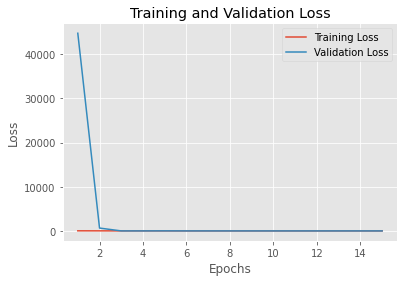

In [72]:
# de la ayudantía 12:

# Grafica tu función de pérdida.

# Creamos la función
import matplotlib.pyplot as plt

def plot_loss(history):
    # Get the training loss from the history object
    training_loss = history.history['loss']

    # Get the validation loss from the history object, if available
    validation_loss = history.history.get('val_loss', None)

    # Get the number of epochs
    epochs = range(1, len(training_loss) + 1)

    # Plotting the training loss
    plt.plot(epochs, training_loss, label='Training Loss')
    
    if validation_loss is not None:
        # Plotting the validation loss if available
        plt.plot(epochs, validation_loss, label='Validation Loss')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

# Assuming 'history' is the history object returned by model.fit()
plot_loss(history)


Esta función de pérdida evalúa qué tan bien se desempeña el modelo y cuánto se equivoca, es decir, mide la diferencia entre el valor real y el predecido. En este caso, vemos que mejora mucho con entre las primeras dos épocas, sin embargo, es difícil medir el desempeño más adelante, pues la gráfica tiene una escala muy grande. Aún así es de utilidad para ver el contraste en el aprendizaje, y ver cuántas épocas mínimas son necesarias para mejorar el algoritmo.

###Comparación de modelos
A continuación, responde las siguientes preguntas relacionadas a comparar ambos tipos de redes neuronales:

* ¿Cuál de los modelos tiene un mejor *accuracy*?

Como podemos apreciar, el primero. Esto probablemente porque este posee información mucho más específica de muchos aspectos que aumentan el precio de la casa, mientras que el otro solo muestra una faceta.

* ¿Qué rangos de precios tienen un mejor rendimiento? ¿Y cuáles el peor? ¿Depende del modelo?

In [87]:
# haremos listas para guardar los rangos:

bajo_500 = []
bajo_1k = []
bajo_3k = []
sobre_3k = []

for i in range(0, 1000):
    if y_test_original[i] < 5:
        bajo_500.append(i)  # vamos guardando los valores de los rangos
    elif 5 <= y_test_original[i] < 10:
        bajo_1k.append(i)
    elif 10 <= y_test_original[i] < 30:
        bajo_3k.append(i)
    elif y_test_original[i] >= 30:
        sobre_3k.append(i)

suma_cnn = 0 # aquí calcularemos el accuracy de los modelos
suma_mlp = 0 
for i in bajo_500:
    suma_cnn += 100*abs(y_test_original[i] - ypred_original[i])/y_test_original[i]
    suma_mlp += 100*abs(y_test[i] - y_predt[i])/y_test[i]

try:
    valor = suma_cnn/len(bajo_500) # imprimimos el valor para CNN en el rango bajo 500
    print("para valores menores a 500 tenemos un accuracy promedio para cnn de: ", valor)
except ZeroDivisionError:
    print("no tenemos valores aquí")

try:
    valor = suma_mlp/len(bajo_500) # imprimimos el valor para MLP en el rango bajo 500
    print("para valores menores a 500 tenemos un accuracy promedio para mlp de: ", int(valor))
except ZeroDivisionError:
    print("no tenemos valores aquí")

suma_cnn = 0
suma_mlp = 0 
for i in bajo_1k:
    suma_cnn += 100*abs(y_test_original[i] - ypred_original[i])/y_test_original[i]
    suma_mlp += 100*abs(y_test[i] - y_predt[i])/y_test[i]

try:
    valor = suma_cnn/len(bajo_1k) 
    print(" \n para valores menores a 1000 tenemos un accuracy promedio para cnn de: ", int(valor))
except ZeroDivisionError:
    print(" \n no tenemos valores aquí")

try:
    valor = suma_mlp/len(bajo_1k)
    print("para valores menores a 1000 tenemos un accuracy promedio para mlp de: ", int(valor))
except ZeroDivisionError:
    print("no tenemos valores aquí")

suma_cnn = 0
suma_mlp = 0 
for i in bajo_3k:
    suma_cnn += 100*abs(y_test_original[i] - ypred_original[i])/y_test_original[i]
    suma_mlp += 100*abs(y_test[i] - y_predt[i])/y_test[i]

try:
    valor = suma_cnn/len(bajo_3k) 
    print(" \n para valores menores a 3000 tenemos un accuracy promedio para cnn de: ", int(valor))
except ZeroDivisionError:
    print(" \n no tenemos valores aquí")

try:
    valor = suma_mlp/len(bajo_3k)
    print("para valores menores a 3000 tenemos un accuracy promedio para mlp de: ", int(valor))
except ZeroDivisionError:
    print("no tenemos valores aquí")

suma_cnn = 0
suma_mlp = 0 
for i in sobre_3k:
    suma_cnn += 100*abs(y_test_original[i] - ypred_original[i])/y_test_original[i]
    suma_mlp += 100*abs(y_test[i] - y_predt[i])/y_test[i]

try:
    valor = suma_cnn/len(sobre_3k) 
    print(" \n para valores mayores a 3000 tenemos un accuracy promedio para cnn de: ", int(valor))
except ZeroDivisionError:
    print(" \n no tenemos valores aquí")

try:
    valor = suma_mlp/len(sobre_3k)
    print("para valores mayores a 3000 tenemos un accuracy promedio para mlp de: ", int(valor))
except ZeroDivisionError:
    print("no tenemos valores aquí")

para valores menores a 500 tenemos un accuracy promedio para cnn de:  inf
para valores menores a 500 tenemos un accuracy promedio para mlp de:  40
 
 para valores menores a 1000 tenemos un accuracy promedio para cnn de:  1090
para valores menores a 1000 tenemos un accuracy promedio para mlp de:  37
 
 para valores menores a 3000 tenemos un accuracy promedio para cnn de:  391
para valores menores a 3000 tenemos un accuracy promedio para mlp de:  31
 
 para valores mayores a 3000 tenemos un accuracy promedio para cnn de:  49
para valores mayores a 3000 tenemos un accuracy promedio para mlp de:  37


C:\Users\kaori\AppData\Local\Temp/ipykernel_26752/499551707.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  suma_cnn += 100*abs(y_test_original[i] - ypred_original[i])/y_test_original[i]


Hice rangos bajo 500 mil, bajo 1 millon, bajo 3 y sobre 3, y comparé para ambos modelos como se puede apreciar. Vemos que en todos los rangos tenemos valores bastante malos, pero por sobre todo para valores bajos es aún peor. CNN obtuvo el peor desempeño en todos los casos, sin embargo, al igual que para mlp, mejora para valores mayores, llegando a acercarse al final..